In [1]:
import numpy as np
import pandas as pd
import gudhi as gd
import matplotlib.pyplot as plt
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils import data
from torch_utils import torch_rips_filtration_and_persistence, torch_cubical_filtration_and_persistence

%matplotlib inline

# Point Cloud 

**Differentiability**

Differentiating in $K=\{\sigma_i\}$ leads a.s. to the following process.

Every component of the filtrations $\Phi$ is the maximum among (convex) differentiable function, so it is a.s. locally differentiable in a neighboorhood $U$. 

$\mathcal{Pers}$ is a.s. locally a permutation $M_k$ in a neighboorood $O_k$ such that $\Phi(K) \in O_k$. 

$E$ is a differentiable function on $\mathcal{Pers}(O_k)$ (that is an open set cause it is the image of a permutaion of an open set) so we get that the following expression of the differential in the open set $ (E \circ Pers)^{-1}(O_k) \cap U$:

$\nabla F = \nabla E_{|Pers(O_k)} \circ M_k \circ  \nabla \Phi$

**Algorithms**

From the reference we can see that https://geometrica.saclay.inria.fr/team/Fred.Chazal/papers/CGLcourseNotes/main.pdf :

(algorithm 11.2) every complex of dimension $k+1$ of the filtrations creates an homology class of $H_{k+1}$ if it is positive, or kill a class of $H_k$ if it is negative.

So we can conlcude that for the persistence of $H_k$:

- only the skeleton $\mathcal{Sk}_{k+1} K$ it is important.

- only the persistence pairs that beghin with a complex of dimension $k$ matters.

This is why in the emplementation of the following example, where only $H_1$ matters, only the 2-skeleton of the Rips-filtration is used and only finite length bar that are created by a complex of dimension 1 (and killed by one of dimension 2) are selected.

**Subgradient**

Definition and explanantion of the subgradient for convex function and max-function: 

https://stanford.edu/class/ee364b/lectures/subgradients_notes.pdf

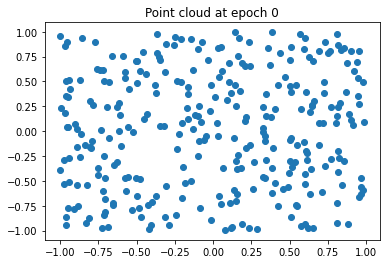

In [7]:
np.random.seed(1)
init = np.array(np.random.uniform(high=1., low=-1., size=(300, 2)), dtype=np.float32)

plt.figure()
plt.scatter(init[:,0], init[:,1])
plt.title('Point cloud at epoch 0')

plt.show()

In [8]:
x = nn.Parameter(torch.FloatTensor(init))


optimizer = torch.optim.SGD([x], lr=1e-01)
lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=0.96)

n_iter = 3000
sigma = 1e-03

losses = []
for i in range(n_iter):
    pers_pairs = torch_rips_filtration_and_persistence(x)

    # resolving for ||x - <x, v>v||^2 with v the diagonal versor we got (x_1 - x_2)^2 / 2

    t_loss = - torch.sum((pers_pairs[:, 0] - pers_pairs[:, 1])**2) / 2
    reg_loss = torch.sum(torch.maximum(torch.abs(x)-1, torch.zeros_like(x)))

    loss = t_loss + reg_loss

    _loss = loss.detach().numpy()
    losses.append(_loss)

    loss.backward()

    x.grad = x.grad + torch.normal(0., sigma, x.size())

    optimizer.step()
    optimizer.zero_grad()
    if ((i+1) % 10) == 0:
        lr_scheduler.step()

        print(f"epoch: {i+1}  loss: {_loss}")

epoch: 10  loss: -0.39147597551345825
epoch: 20  loss: -0.5298035144805908
epoch: 30  loss: -0.5745601058006287
epoch: 40  loss: -0.678118884563446
epoch: 50  loss: -0.7194097638130188
epoch: 60  loss: -0.751319408416748
epoch: 70  loss: -0.8069151639938354
epoch: 80  loss: -0.8163109421730042
epoch: 90  loss: -0.8392259478569031
epoch: 100  loss: -0.8703222870826721
epoch: 110  loss: -0.9139783382415771
epoch: 120  loss: -0.9110809564590454
epoch: 130  loss: -0.9630793333053589
epoch: 140  loss: -0.962378740310669
epoch: 150  loss: -1.0078777074813843
epoch: 160  loss: -1.0055017471313477
epoch: 170  loss: -1.0090025663375854
epoch: 180  loss: -1.0215216875076294
epoch: 190  loss: -1.0218491554260254
epoch: 200  loss: -1.0369521379470825
epoch: 210  loss: -1.0874073505401611
epoch: 220  loss: -1.057199239730835
epoch: 230  loss: -1.0824685096740723
epoch: 240  loss: -1.1032850742340088
epoch: 250  loss: -1.108860969543457
epoch: 260  loss: -1.1289949417114258
epoch: 270  loss: -1.1252

KeyboardInterrupt: 

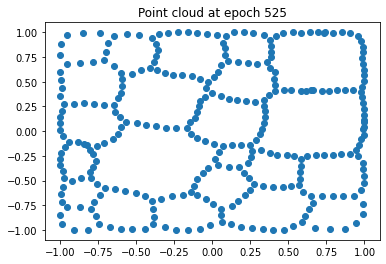

In [10]:
out = x.detach().numpy()

plt.figure()
plt.scatter(out[:,0], out[:,1])
plt.title(f'Point cloud at epoch {i}')
plt.show()

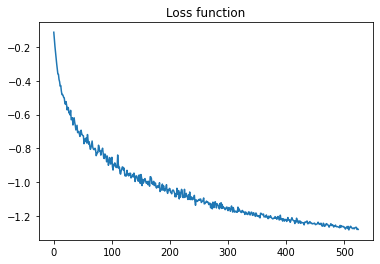

In [11]:
plt.figure()
plt.plot(losses)
plt.title(f'Loss function')
plt.show()

# Image Noise reduction

In [16]:
I = np.array(pd.read_csv('data/mnist_test.csv', header=None, sep=','), dtype=np.float32)
idx = np.argwhere(I[:,0] == 8)
image = np.reshape(-I[idx[8],1:], [28,28])
image = (image-image.min())/(image.max()-image.min())
image_clean = np.array(image)
image[2:5,2:5]        -= 0.6
image[25:27,25:27]    -= 0.6
image[25:27,2:5]      -= 0.6
image[1:4,24:26]      -= 0.6

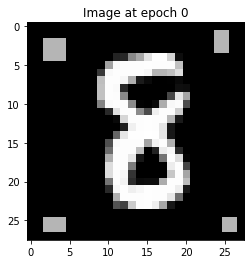

In [17]:
plt.figure()
plt.imshow(image, cmap='Greys')
plt.title('Image at epoch 0')

plt.show()

In [18]:
x = nn.Parameter(torch.FloatTensor(image))


optimizer = torch.optim.SGD([x], lr=1e-02)
lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=0.96)

n_iter = 3000
sigma = 1e-03

alpha = 10.
gamma = 1.

losses = []
for i in range(n_iter):
    pers_pairs = torch_cubical_filtration_and_persistence(x)

    t_loss = alpha * torch.sum(torch.abs(pers_pairs[:, 0] - pers_pairs[:, 1]))
    reg_loss = gamma * torch.sum(torch.min(torch.abs(x), torch.abs(1.- x)))

    loss = t_loss + reg_loss

    _loss = loss.detach().numpy()
    losses.append(_loss)

    loss.backward()

    x.grad = x.grad + torch.normal(0., sigma, x.size())

    optimizer.step()
    optimizer.zero_grad()
    if ((i+1) % 10) == 0:
        lr_scheduler.step()

        print(f"epoch: {i+1}  loss: {_loss}")

epoch: 10  loss: 99.24546813964844
epoch: 20  loss: 70.10995483398438
epoch: 30  loss: 68.7956314086914
epoch: 40  loss: 48.70992660522461
epoch: 50  loss: 48.74152374267578
epoch: 60  loss: 47.27167510986328
epoch: 70  loss: 39.14284896850586
epoch: 80  loss: 44.57096481323242
epoch: 90  loss: 41.57128143310547
epoch: 100  loss: 36.366851806640625
epoch: 110  loss: 35.67399978637695
epoch: 120  loss: 34.55281448364258
epoch: 130  loss: 33.91387939453125
epoch: 140  loss: 30.8222599029541
epoch: 150  loss: 32.39421463012695
epoch: 160  loss: 33.409759521484375
epoch: 170  loss: 24.190969467163086
epoch: 180  loss: 25.821264266967773
epoch: 190  loss: 24.397857666015625
epoch: 200  loss: 24.346725463867188
epoch: 210  loss: 24.48862075805664
epoch: 220  loss: 22.257568359375
epoch: 230  loss: 23.370174407958984
epoch: 240  loss: 21.05301284790039
epoch: 250  loss: 19.656871795654297
epoch: 260  loss: 21.534509658813477
epoch: 270  loss: 19.68808364868164
epoch: 280  loss: 16.30410957336

epoch: 2220  loss: 0.005315978080034256
epoch: 2230  loss: 0.00543785747140646
epoch: 2240  loss: 0.006099828518927097
epoch: 2250  loss: 0.006333054043352604
epoch: 2260  loss: 0.004789439029991627
epoch: 2270  loss: 0.004847730975598097
epoch: 2280  loss: 0.004863746464252472
epoch: 2290  loss: 0.0048437342047691345
epoch: 2300  loss: 0.0038152234628796577
epoch: 2310  loss: 0.003501730505377054
epoch: 2320  loss: 0.004543811082839966
epoch: 2330  loss: 0.004039302468299866
epoch: 2340  loss: 0.003297220915555954
epoch: 2350  loss: 0.0036780997179448605
epoch: 2360  loss: 0.0032926492858678102
epoch: 2370  loss: 0.0028457357548177242
epoch: 2380  loss: 0.0029487241990864277
epoch: 2390  loss: 0.002652233000844717
epoch: 2400  loss: 0.0027716555632650852
epoch: 2410  loss: 0.0022148098796606064
epoch: 2420  loss: 0.0024126977659761906
epoch: 2430  loss: 0.0022415926214307547
epoch: 2440  loss: 0.002231844235211611
epoch: 2450  loss: 0.002026517642661929
epoch: 2460  loss: 0.0023040380

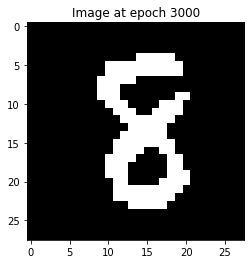

In [19]:
out = x.detach().numpy()

plt.figure()
plt.imshow(out, cmap='Greys')
plt.title('Image at epoch ' + str(i+1))
plt.show()

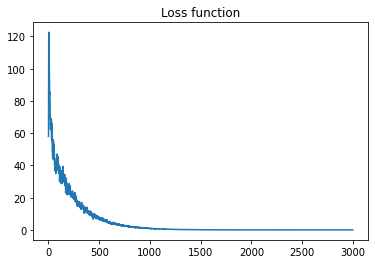

In [20]:
plt.figure()
plt.plot(losses)
plt.title(f'Loss function')
plt.show()